## Time series analysis of azimuth / range offset


In [42]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt

from mintpy.objects import timeseries
from mintpy.utils import readfile, writefile
from mintpy import view

work_dir = '/Users/yunjunz/data/SanAndreas/SenDT42F472/mintpyOffset'
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/data/SanAndreas/SenDT42F472/mintpyOffset


### 1. Estimate offset time-series:

Here is my MintPy configuration file `SanAndreasSenDT42F472.txt`:

```cfg
# vim: set filetype=cfg:
mintpy.load.processor      = isce  #[isce,snap,gamma,roipac], auto for isce
##---------for ISCE only:
mintpy.load.metaFile       = ../master/IW1.xml  #[path2metadata_file], i.e.: ./master/IW1.xml, ./masterShelve/data.dat
mintpy.load.baselineDir    = ../baselines  #[path2baseline_dir], i.e.: ./baselines
##---------offset datasets:
mintpy.load.azOffFile      = ../merged/offsets/*/filtAz*.off  #[path2az_off_file], optional
mintpy.load.rgOffFile      = ../merged/offsets/*/filtRa*.off  #[path2rg_off_file], optional
mintpy.load.offSnrFile     = ../merged/offsets/*/*_snr*.bip   #[path2off_SNR_file], optional
##---------geometry datasets:
mintpy.load.demFile        = ../merged/offsets/geom_master/hgt.rdr  #[path2hgt_file]
mintpy.load.lookupYFile    = ../merged/offsets/geom_master/lat.rdr  #[path2lat_file], not required for geocoded data
mintpy.load.lookupXFile    = ../merged/offsets/geom_master/lon.rdr  #[path2lon_file], not required for geocoded data
mintpy.load.incAngleFile   = ../merged/offsets/geom_master/los.rdr  #[path2los_file], optional
mintpy.load.azAngleFile    = ../merged/offsets/geom_master/los.rdr  #[path2los_file], optional
mintpy.load.shadowMaskFile = ../merged/offsets/geom_master/shadowMask.rdr  #[path2shadow_file], optional
mintpy.load.waterMaskFile  = ../merged/offsets/geom_master/waterMask.rdr  #[path2water_mask_file], optional

mintpy.network.connNumMax                       = 2
```

Run the following in the terminal:

```bash
smallbaselineApp.py SanAndreasSenDT42F472.txt --end modify_network
ifgram_inversion.py  inputs/ifgramStack.h5 -i azimuthOffset --water-mask waterMask.h5
ifgram_inversion.py  inputs/ifgramStack.h5 -i rangeOffset --water-mask waterMask.h5
timeseries2velocity.py timeseriesAz.h5 -o velocityAz.h5
timeseries2velocity.py timeseriesRg.h5 -o velocityRg.h5
```

### 2. Prepare mask

create HDF5 file: mask.h5 with w mode
create dataset /mask of bool       in size of (109, 150)           with compression=None
finished writing to mask.h5


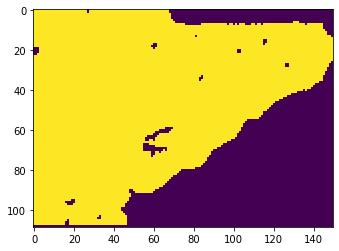

In [21]:
## temporal coherence
min_tcoh = 0.999
tcoh_az = readfile.read('temporalCoherenceAz.h5')[0]
tcoh_rg = readfile.read('temporalCoherenceRg.h5')[0]
mask = np.multiply(tcoh_az > min_tcoh, tcoh_rg > min_tcoh)

## water
water_mask = readfile.read('waterMask.h5')[0]
mask *= water_mask

## velocity
max_vel = 1 # m/year
vel_az = readfile.read('velocityAz.h5', datasetName='velocity')[0]
vel_rg = readfile.read('velocityRg.h5', datasetName='velocity')[0]
mask *= np.abs(vel_az) < max_vel
mask *= np.abs(vel_rg) < max_vel

## write to file
mask_file = 'mask.h5'
atr = readfile.read_attribute('temporalCoherenceAz.h5')
atr['FILE_TYPE'] = 'mask'
atr['DATA_TYPE'] = 'bool'
atr['UNIT'] = '1'
writefile.write(mask, out_file=mask_file, metadata=atr)

## plot
plt.figure()
plt.imshow(mask)
plt.show()

run view.py in MintPy release version v1.2.0-36, release date 2020-03-05
input file is timeseries file: /Users/yunjunz/data/SanAndreas/SenDT42F472/mintpyOffset/timeseriesRg.h5 in float32 format
file size in y/x: (109, 150)
num of datasets in file timeseriesRg.h5: 93
datasets to exclude (0):
[]
datasets to display (93):
['timeseries-20151120', 'timeseries-20151214', 'timeseries-20160107', 'timeseries-20160131', 'timeseries-20160224', 'timeseries-20160319', 'timeseries-20160412', 'timeseries-20160506', 'timeseries-20160530', 'timeseries-20160810', 'timeseries-20160903', 'timeseries-20170113', 'timeseries-20170606', 'timeseries-20170618', 'timeseries-20170630', 'timeseries-20170712', 'timeseries-20170724', 'timeseries-20170805', 'timeseries-20170817', 'timeseries-20170910', 'timeseries-20171004', 'timeseries-20171016', 'timeseries-20171028', 'timeseries-20171109', 'timeseries-20171121', 'timeseries-20171203', 'timeseries-20171215', 'timeseries-20171227', 'timeseries-20180108', 'timeseries

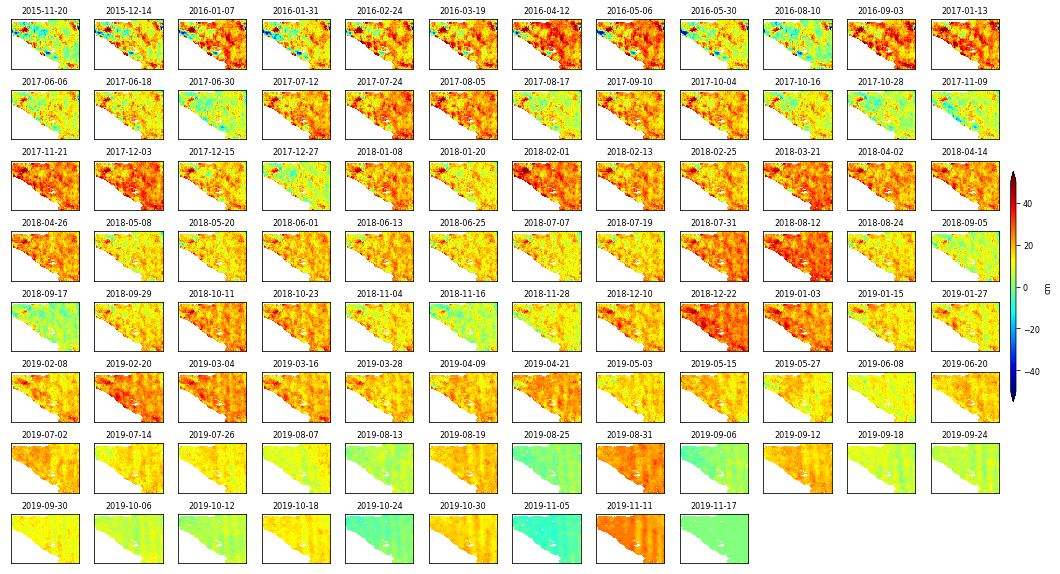

In [24]:
view.main('timeseriesRg.h5 -m mask.h5 -v -50 50 --ref-date 20191117 '.split())

### 3. Get median and mean offset for each acquisition

open timeseries file: timeseriesRg.h5


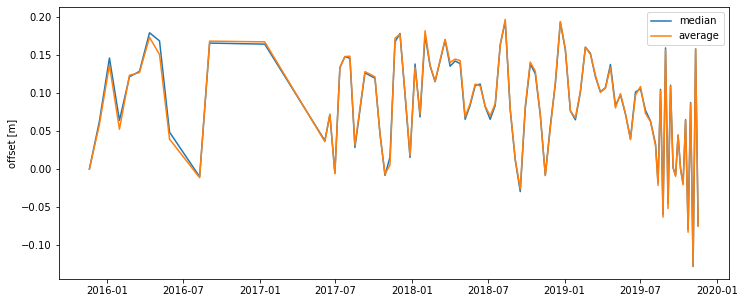

In [57]:
ts_file = 'timeseriesRg.h5'
ts_obj = timeseries(ts_file)
ts_obj.open()

## read data
ts_data, atr = readfile.read(ts_file)
ts_data = ts_data.reshape(ts_obj.numDate, -1) # flatten
ts_data[:, mask.flatten()==0] = np.nan #mask

## calculate median and mean
ts_med = np.nanmedian(ts_data, axis=-1)
ts_avg = np.nanmean(ts_data, axis=-1)

## plot
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(ts_obj.times, ts_med, label='median')
ax.plot(ts_obj.times, ts_avg, label='average')
ax.set_ylabel('offset [m]')
plt.legend()
plt.show()

open timeseries file: timeseriesAz.h5


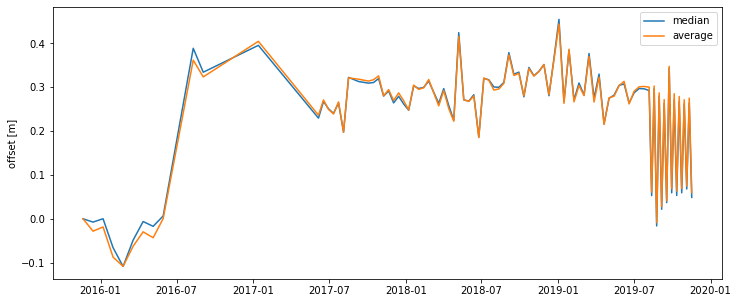

In [58]:
ts_file = 'timeseriesAz.h5'
ts_obj = timeseries(ts_file)
ts_obj.open()

## read data
ts_data, atr = readfile.read(ts_file)
ts_data = ts_data.reshape(ts_obj.numDate, -1) # flatten
ts_data[:, mask.flatten()==0] = np.nan #mask

## calculate median and mean
ts_med = np.nanmedian(ts_data, axis=-1)
ts_avg = np.nanmean(ts_data, axis=-1)

## plot
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(ts_obj.times, ts_med, label='median')
ax.plot(ts_obj.times, ts_avg, label='average')
ax.set_ylabel('offset [m]')
plt.legend()
plt.show()